In [1]:
import os
import sys
import numpy as np 
import matplotlib.pyplot as plt
import tqdm


<span style="color: orange;">

## **0.2**

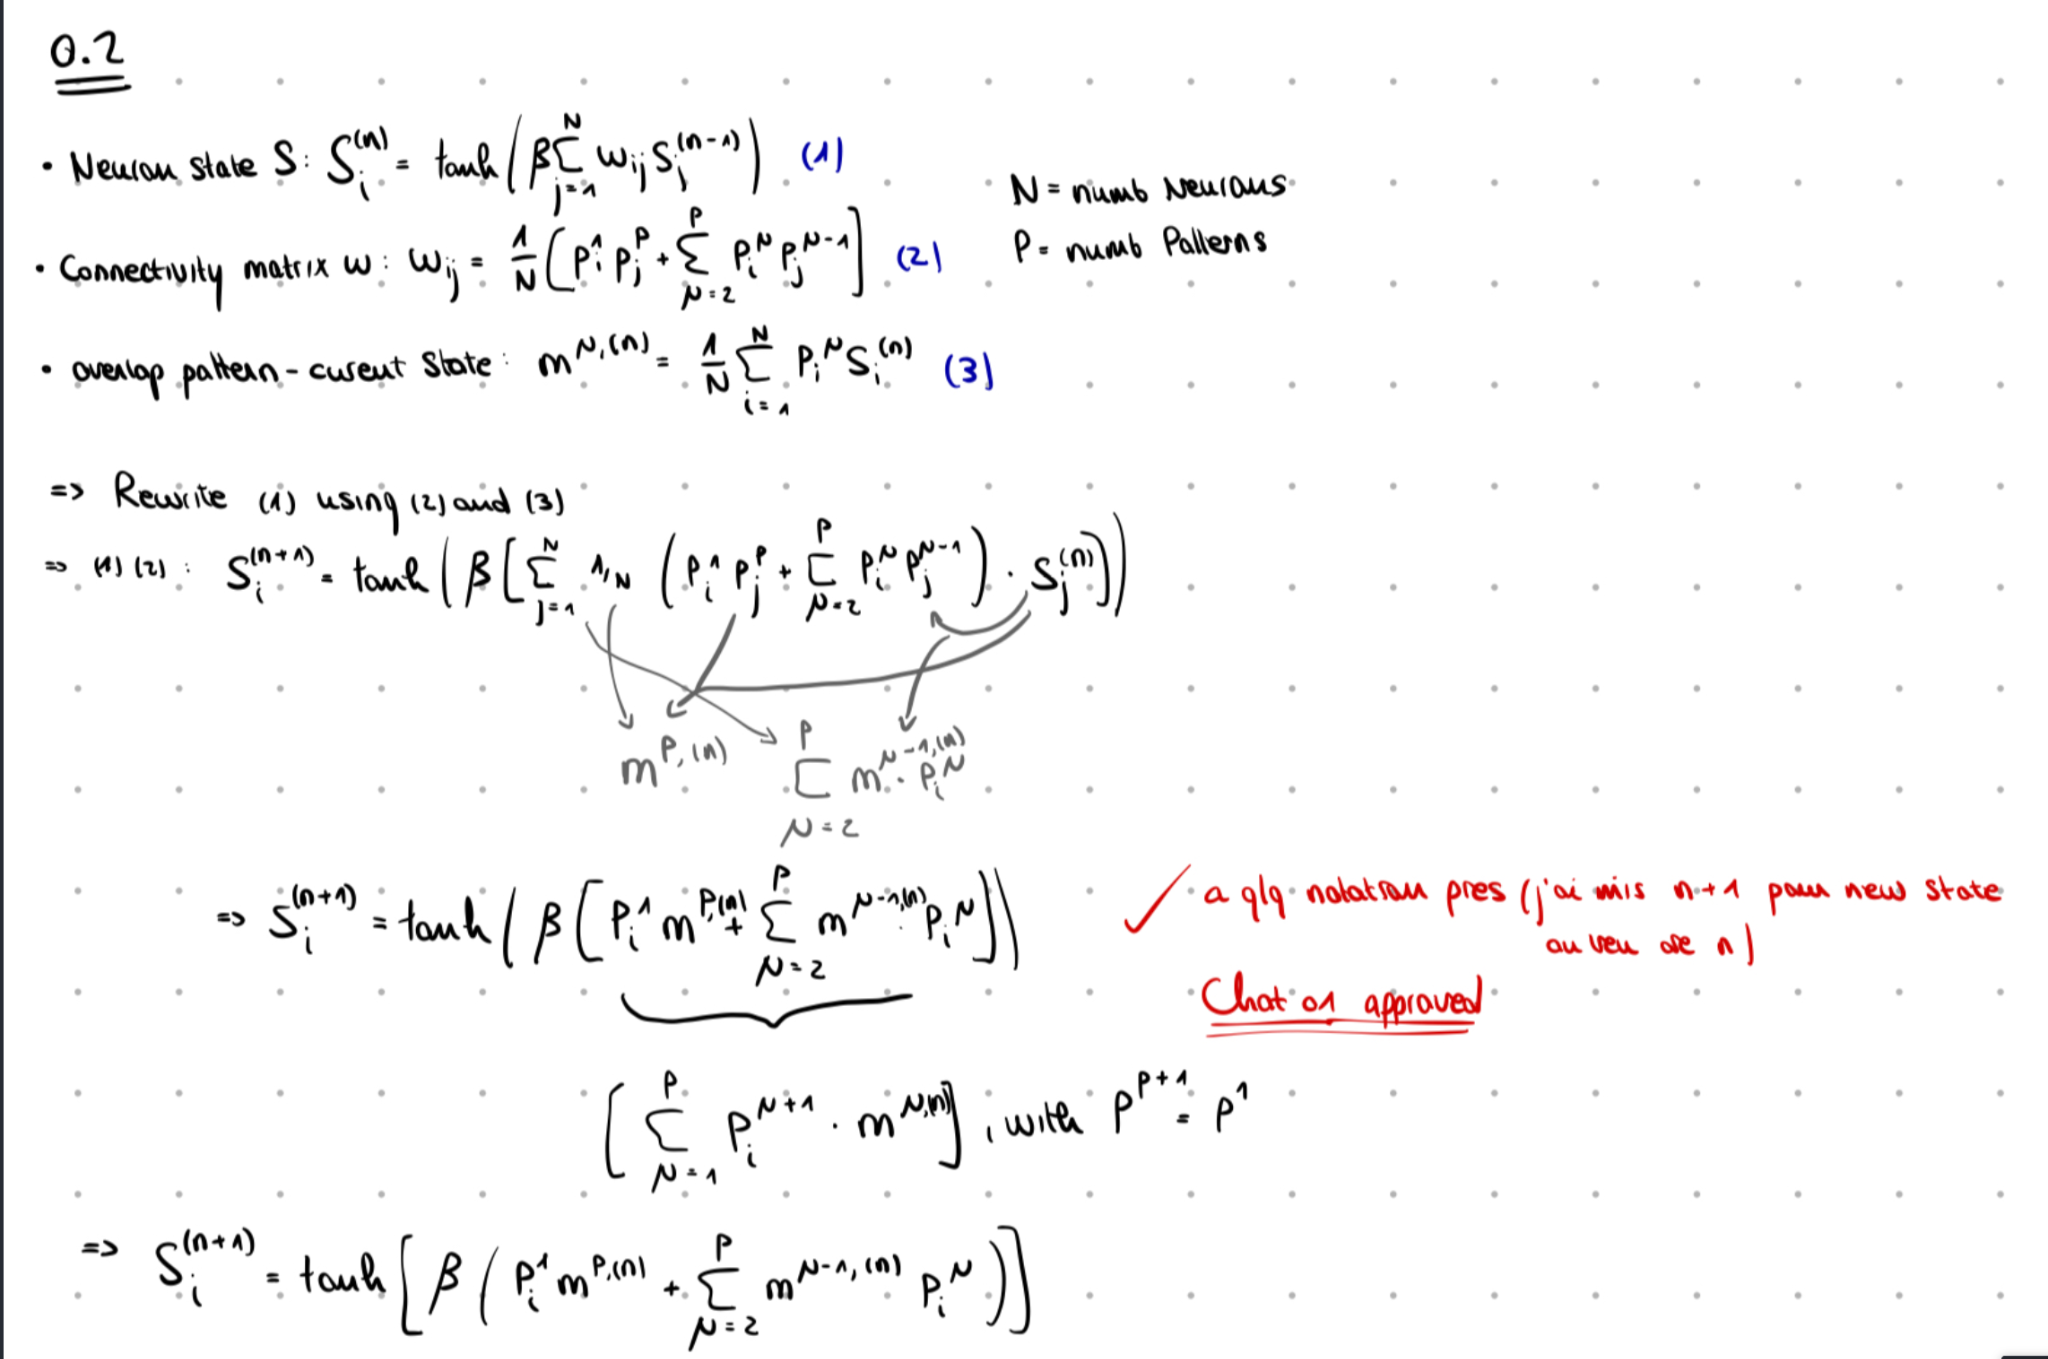

Given the following equation, 
- Neural state \(S\):
$$
S_{i}^{(n)}
\;=\;
\tanh\Bigl(\beta \sum_{j=1}^N w_{ij}\,S_{j}^{(n-1)}\Bigr)
\quad (1)
$$

- Connectivity matrix \(w\):
$$
w_{ij}
\;=\;
\frac{1}{N}
\Bigl[
  p_{i}^1\,p_{j}^P
  \;+\;
  \sum_{\mu=2}^P
    p_{i}^{\mu}\,p_{j}^{\mu-1}
\Bigr]
\quad (2)
$$

- Overlap (pattern–current state),
$$
m_{(n)}^\mu
\;=\;
\frac{1}{N}
\sum_{i=1}^N
p_i^\mu \, S_i^{(n)}
\quad (3)
$$

We can first rewrite $(1)$ using $(2)$, we obtain,
$$
\begin{aligned}
S_i^{(n+1)}
&=
\tanh\Bigl[
  \beta
  \Bigl(
    \frac{1}{N}
    \sum_{j=1}^N
      \Bigl(
        p_i^1\,p_j^P
        \;+\;
        \sum_{\mu=2}^P
          p_i^\mu\,p_j^{\mu-1}
      \Bigr)\,
      S_j^{(n)}
  \Bigr)
\Bigr].
\end{aligned}
$$

Now, using $(3)$ we can simplify the sum over $j$ and we get,
$$
\begin{aligned}
S_i^{(n+1)}
&=
\tanh\Bigl[
  \beta
  \Bigl(
    p_i^1\,m_{(n)}^P
    \;+\;
    \sum_{\mu=2}^P
      p_i^\mu\,m_{(n)}^{\mu-1}
  \Bigr)
\Bigr].
\end{aligned}
$$

With, 
$$  
\Bigl(
    p_i^1\,m_{(n)}^P
    \;+\;
    \sum_{\mu=2}^P
      p_i^\mu\,m_{(n)}^{\mu-1}
  \Bigr) = \sum_{\mu=1}^P p_i^\mu\,m_{(n)}^{\mu-1} \text{, with } p^{P+1} = p^{1}

$$

<span style="color: orange;">

## **0.3**

We assume :
- A large $\beta$ so that $\tanh(\beta\,x) \approx \mathrm{sign}(x)$.  
- Only orthogonal patterns so $\sum_{i=1}^N p_i^\mu\,p_i^\nu = 0$ when $\mu\neq\nu$.  


First let's compute the overlap variable at $n = 0$ assumin $S_i^{(0)}= p_i^1$,

$$
   m^\mu_{(0)} 
   \;=\; \frac{1}{N}\,\sum_{i=1}^N p_i^\mu\,S_i^{(0)} 
   \;=\; \frac{1}{N}\,\sum_{i=1}^N p_i^\mu\,p_i^1.
$$
  
By orthogonality, this sum is $1$ if $\mu=1$, and $0$ otherwise. Thus $m^1_{(0)} = 1$ and $m^\mu_{(0)}=0$ for $\mu=2,\ldots,P$.

We can now compute the first state, $n = 1$,

From the derived update rule,
$$
S_i^{(1)} 
\;=\; 
\tanh\!\Bigl[
  \beta\,\Bigl(p_i^1\,m^P_{(0)} \;+\;\sum_{\mu=2}^P p_i^\mu\,m^{\mu-1}_{(0)}\Bigr)
\Bigr].
$$

We can see that because $m^\mu_{(0)}=1$ for $\mu = 1$ and $0$ otherwise, the only nonzero term in the sum is when $\mu=2$ ($m^{2-1}_{(0)} = m^1_{(0)}=1)$.  
Thus we get $\tanh(\beta\,p_i^2)$. With the asumption of a large $\beta$, $\tanh(\beta\,p_i^2) \approx \mathrm{sign}(p_i^2) = p_i^2$. The first state is thus given by
$$
S_i^{(1)} = p_i^{2}
$$

Now we can see that the same logic repeats :
1) At time $n=1$, the state is $p^2$.  
2) Therfore $m^\mu_{(1)}=1$ if $\mu = 2$ and $0$ otherwise. 
3) Computing the update rule we get $S^{(2)} = p^3$.  
4) Iterating further will thus form a cyclic sequence : 
$$
p^1
\;\to\;
p^2
\;\to\;
\cdots
\;\to\;
p^P
\;\to\;
p^1
\;\to\;
\cdots
$$

## C'est assez ?? 




## **Ex 0. Getting Started: Cyclic Hopfield model**


In [2]:
def generate_patterns(P,N): 
    """
    Generates P random flatt patterns of size N 
    Args:
        P (int): Number of patterns
        N (int): Size of each pattern
    """
    return np.random.choice([-1,1], size =(P, N))

def compute_overlaps(patterns, S): 
    """"
    Computes the overlaps between patterns P and state S
    Args:
        patterns (numpy.ndarray): Patterns of size (P, N)
        S (numpy.ndarray): State of size (N,)
    """
    N = patterns.shape[1]
    m = np.dot(patterns,S) / N
    return m #(P,)

def compute_state_S(m,patterns, S, beta): 
    """
    Computes the state S
    Args:
        patterns (numpy.ndarray): Patterns of size (P, N)
        S (numpy.ndarray): State of size (N,)
        beta (float): Scalar parameter
    """
    m_minus_1 = np.roll(m, 1)
    S_update = np.tanh(beta * np.dot(m_minus_1, patterns)) 
    return S_update #(N,)

def simulation(P = 10, N = 100, beta = 4, n_max = None, plot= True, control_cycle = True, verbose = True):
    """
    Simulates the evolution of the state S and the overlaps m
    Args:
        P (int, optional): Number of patterns
        N (int, optional): Number of neurons
        beta (int, optional): Scalar parameter
        n_max (int, optional): Number of iterations
        plot (bool, optional): Whether to plot the overlaps evolution
        control_cycle (bool, optional): Whether to control the cycle of overlaps and early stop the simulation
    """
    if n_max is None :
        n_max = 2* P
    m_track = []
    patterns = generate_patterns(P, N) 
    S= patterns[0,:].copy().astype(float) #initial state is the first pattern
    S_track = [S.copy()]
    previous_m = None
    for n,i in enumerate(range(n_max)): 
        m = compute_overlaps(patterns, S)
        S = compute_state_S(m, patterns, S, beta)
        S_track.append(S.copy())
        m_track.append(m)
        if control_cycle :
            max_overlap = np.argmax(m)
            if n == 0 : 
                previous_m = max_overlap
                continue
            else :
                if previous_m == P-1 : 
                    if max_overlap == 0 or max_overlap == P-1 : 
                        previous_m = max_overlap
                        if n == n_max - 1 : 
                            retreived = True
                            if verbose : 
                                print("Simulation finished | Cycle retreived")
                        continue
                    else : 
                        previous_m = max_overlap
                        retreived = False     
                        if verbose :                    
                            print("Early stopping itt: {} | Cycle not retreived in correct order {} -> {}".format(n,previous_m, max_overlap))
                        break
                if max_overlap == previous_m or max_overlap == previous_m + 1 : 
                    previous_m = max_overlap
                    if n == n_max - 1 : 
                        retreived = True
                        if verbose : 
                            print("Simulation finished | Cycle retreived")
                    continue
                else : 
                    previous_m = max_overlap
                    retreived = False
                    if verbose : 
                        print("Early stopping itt: {} | Cycle not retreived in correct order {} -> {}".format(n,previous_m, max_overlap))
                    break
        

    m_track = np.array(m_track)
    S_track = np.array(S_track)
    if plot : 
        plt.figure(figsize=(10, 5))
        for mu in range(P):
            plt.plot(m_track[:, mu], label=f'Pattern_{mu + 1}')
        plt.title('Overlaps Evolution')
        plt.xlabel('Iteration')
        plt.ylabel('Overlap')
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
           ncol=5, fancybox=True,)
        # plt.tight_layout()
        plt.show()
    if control_cycle : 
        return  patterns, S_track, m_track, retreived
    else:   
        return  patterns, S_track, m_track

## **Ex 1. Sequence storage and retrieval**


## **(0.4)**

Simulation finished | Cycle retreived


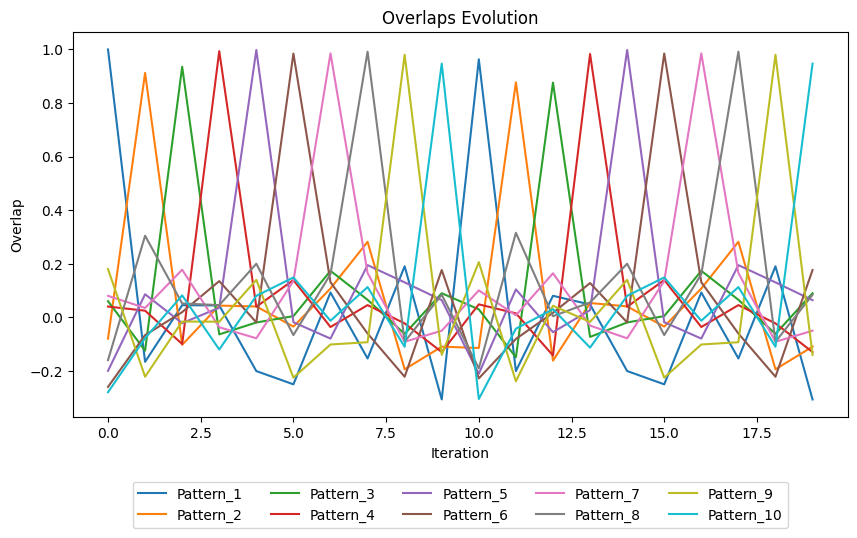

Early stopping itt: 6 | Cycle not retreived in correct order 39 -> 39


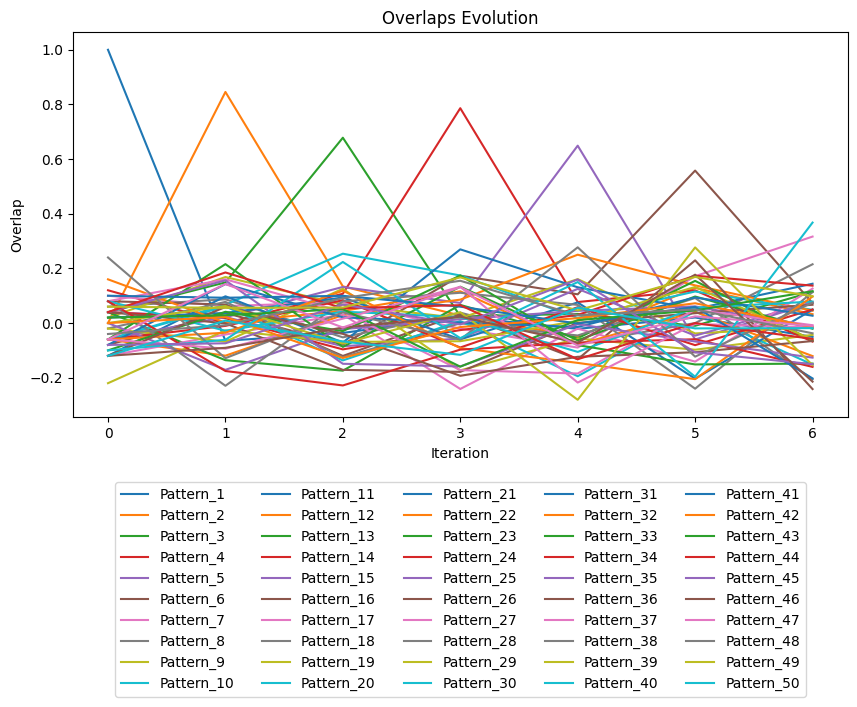

In [3]:
# Cycle retrieving control implemented directly in sumulation function allowing early stop
sim_P10 = simulation(verbose = True)
sim_P50 = simulation(P = 50, verbose = True)

Alphas: 100%|██████████| 40/40 [00:00<00:00, 444.44it/s]


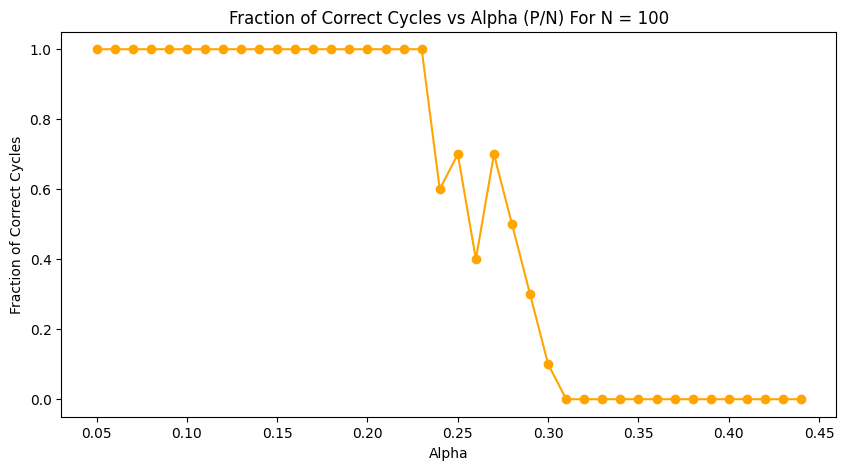

Alphas: 100%|██████████| 40/40 [00:19<00:00,  2.10it/s]


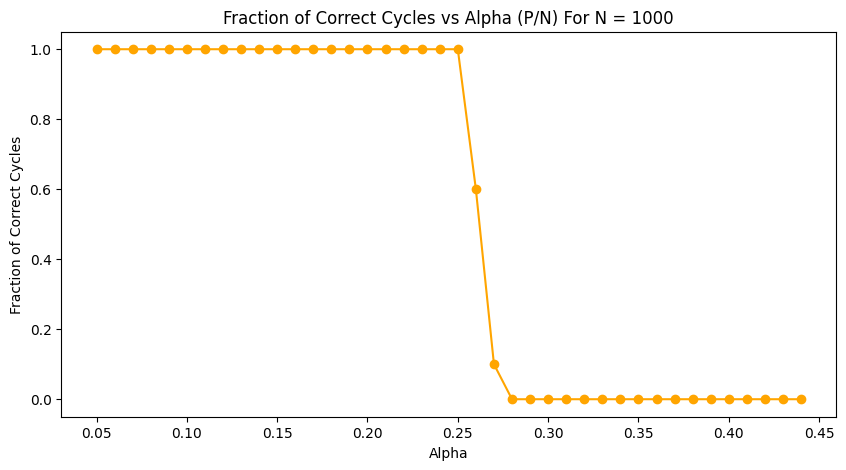

In [4]:
def plot_frac_retreived_cycles_fct_network_load(N, eval_per_a = 10, alphas = np.arange(0.05, 0.45, 0.01), verbose = False):
    retreived_frac_func_alpha = {}
    for a in tqdm.tqdm(alphas, desc = "Alphas"): 
        correct_cycle = 0
        for i in range(eval_per_a):
            P = int(N * a)
            _,_,_,retreived = simulation(P = P, N = N, beta = 4, n_max = 2 * P, plot= False, control_cycle = True, verbose = verbose)
            if retreived :
                correct_cycle += 1
        retreived_frac_func_alpha[a] = correct_cycle / eval_per_a
    x = sorted(retreived_frac_func_alpha.keys())
    y = [retreived_frac_func_alpha[k] for k in x]
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, marker='o', color = "orange")
    plt.title('Fraction of Correct Cycles vs Alpha (P/N) For N = {}'.format(N))
    plt.xlabel('Alpha')
    plt.ylabel('Fraction of Correct Cycles')
    plt.show()
    return retreived_frac_func_alpha

frac_alpha_N100 = plot_frac_retreived_cycles_fct_network_load(N = 100)
frac_alpha_N1000 = plot_frac_retreived_cycles_fct_network_load(N = 1000)
    

### **1.4 Bonus.**

Faudra expliqer athematiquement pk n peut juste sommer les weight initialiser sur chaque patern individuelement etc....


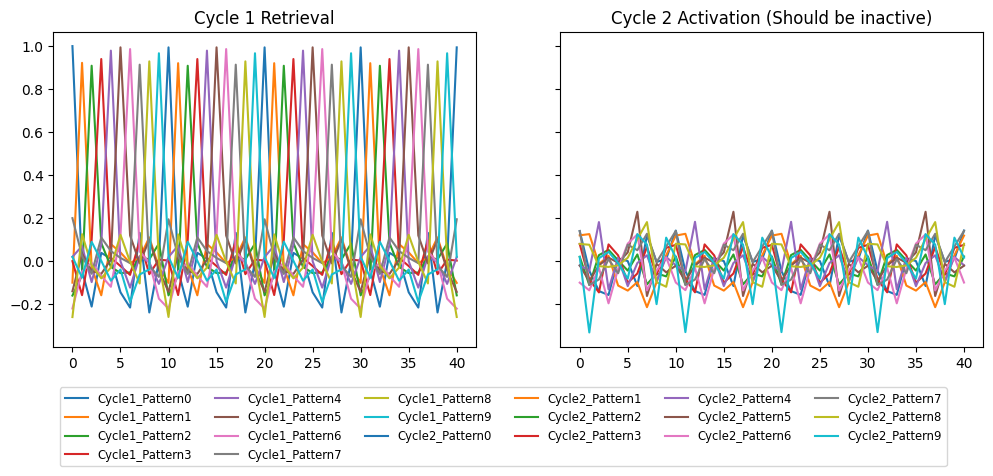

In [5]:
def generate_two_patterns_cycle(P_half, N):
    cycle1 = np.random.choice([-1, 1], size=(P_half, N))
    cycle2 = np.random.choice([-1, 1], size=(P_half, N))
    return cycle1, cycle2

def build_W_from_one_cycle_patterns(patterns):
    P, N = patterns.shape
    W = np.zeros((N, N))
    for mu in range(P):
        prev = (mu - 1) % P
        W += np.outer(patterns[mu], patterns[prev])
    return W / N

cycle1, cycle2 = generate_two_patterns_cycle(10, 100)
W1 = build_W_from_one_cycle_patterns(cycle1)
W2 = build_W_from_one_cycle_patterns(cycle2)
W_total = W1 + W2 

def S_update(W, S0, beta, n_max):
    S = S0.copy()
    S_track = [S.copy()]
    for i in range(n_max):
        S = np.tanh(beta * np.dot(W,S))
        S_track.append(S.copy())
    return np.array(S_track)


def compute_overlaps(S_track, patterns):
    return np.dot(S_track, patterns.T) / patterns.shape[1]  

S1_0 = cycle1[0].copy()
S1 = S_update(W_total, S1_0, beta=4, n_max=40)
m1 = compute_overlaps(S1, cycle1)
m2 = compute_overlaps(S1, cycle2) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

ax1.set_title("Cycle 1 Retrieval")
lines1 = [ax1.plot(m1[:, i], label=f"Cycle1_Pattern{i}") for i in range(m1.shape[1])]

ax2.set_title("Cycle 2 Activation (Should be inactive)")
lines2 = [ax2.plot(m2[:, i], label=f"Cycle2_Pattern{i}") for i in range(m2.shape[1])]


handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles1 + handles2, labels1 + labels2,
           loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=6, fontsize='small')

plt.subplots_adjust(bottom=0.25)

plt.show()





In [6]:
# def is_cycle_retreived( P = 10, N = 100, beta = 4, n_max = 20, plot= False, ):
#     """
#     Checks if the cycle is retrieved
#     Args:
#         m_stack (numpy.ndarray): Overlaps of size (n_max, P)
#         P (int, optional): Number of patterns
#         N (int, optional): Number of neurons
#         beta (int, optional): Scalar parameter
#         n_max (int, optional): Number of iterations
#         plot (bool, optional): Whether to plot the overlaps evolution
#     """
#     _, _, m_stack = simulation(P, N, beta, n_max, plot)
#     max_overlap = np.argmax(m_stack, axis=1)
#     prev_index = max_overlap[0]
#     for i in max_overlap[1:]:
#         if prev_index == P-1:
#             if i == prev_index or i == 0 :
#                 prev_index = i
#                 continue
#             else:
#                 print("Cycle not retrieved")
#                 return False
#         if i == prev_index or i == prev_index + 1:
#             prev_index = i
#             continue
#         else:
#             print("Cycle not retrieved")
#             return False
          
#     print("Cycle retrieved")
#     return True
            
        
    
# retreived_10 = is_cycle_retreived()    
# retreived_50 = is_cycle_retreived(P = 50)
  
     
    